## New Section

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.colors

from matplotlib import animation, rc
from IPython.display import HTML

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error,log_loss
from tqdm import tqdm_notebook
import imageio
import seaborn as sns 
from sklearn.datasets import make_blobs

from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green","blue"])

In [3]:
np.random.seed(0)


In [4]:
data, labels = make_blobs(n_samples=1000, centers=20, n_features=10, random_state=0)
print(data.shape, labels.shape)

(1000, 10) (1000,)


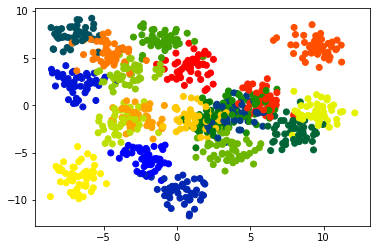

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [6]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

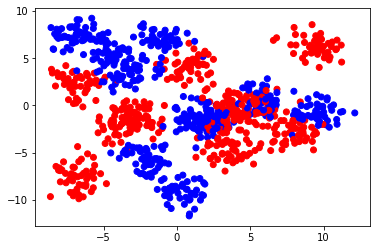

In [7]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape,Y_train.shape,Y_val.shape)

(750, 10) (250, 10) (750,) (250,)


In [9]:
X_train_m, X_val_m, Y_train_m, Y_val_m = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train_m.shape, X_val_m.shape, labels_orig.shape)

(750, 10) (250, 10) (1000,)


In [10]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train_m,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val_m,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 20) (250, 20)


In [139]:
class FFSNNetwork:
  
  def __init__(self, n_inputs, hidden_sizes=[2],int_method='random',activitaion_fun='sigmoid',leaky_slope=0.01):
    self.nx = n_inputs
    self.ny = 1
    self.nh = len(hidden_sizes)
    self.int_method=int_method
    self.activitaion_fun=activitaion_fun
    self.sizes = [self.nx] + hidden_sizes + [self.ny]
    self.leaky_slope=leaky_slope
    np.random.seed(0)
    print(self.sizes)
    
    self.W = {}
    self.B = {}
    self.W_H=[]
    self.B_H=[]
    self.E_H=[]
    self.params={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(self.nh+1):
      self.update_params["v_w"+str(i+1)]=0
      self.update_params["v_b"+str(i+1)]=0
      self.update_params["m_b"+str(i+1)]=0
      self.update_params["m_w"+str(i+1)]=0
      self.prev_update_params["v_w"+str(i+1)]=0
      self.prev_update_params["v_b"+str(i+1)]=0
    if int_method == "random":
      for i in range(self.nh+1):
        self.params["W"+str(i+1)] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.params["B"+str(i+1)]= np.zeros((1, self.sizes[i+1]))
        # self.temp_params["W"+str(i+1)]=self.W[i+1].copy()
        # self.temp_params["B"+str(i+1)]=self.B[i+1].copy()
    elif int_method == "zeros":
      for i in range(self.nh+1):
        self.params["W"+str(i+1)] = np.zeros((self.sizes[i], self.sizes[i+1]))
        self.params["B"+str(i+1)]= np.zeros((1, self.sizes[i+1]))
    elif int_method == "xavier":
      for i in range(self.nh+1):
        self.params["W"+str(i+1)] = np.random.randn(self.sizes[i], self.sizes[i+1])*np.square(1/self.sizes[i])
        self.params["B"+str(i+1)]= np.zeros((1, self.sizes[i+1]))
    elif int_method == "he":
      for i in range(self.nh+1):
        self.params["W"+str(i+1)] = np.random.randn(self.sizes[i], self.sizes[i+1])*np.square(1/(self.sizes[i]/2))
        self.params["B"+str(i+1)]= np.zeros((1, self.sizes[i+1]))



      
  
  def sigmoid(self, X):
    return 1.0/(1.0 + np.exp(-X))
  
  def activation_farwoard_pass(self,X):
    if self.activitaion_fun == "sigmoid":
      return 1.0/(1.0 + np.exp(-X))
    elif self.activitaion_fun == "tanh":
      return np.tanh(X)
    elif self.activitaion_fun == "Relu":
      return np.maximum(0,X)
    elif self.activitaion_fun == "leaky_Relu":
      return np.maximum(self.leaky_slope*X,X)
  
  def grad_farword_pass(self,X):
    if self.activitaion_fun == "sigmoid":
      return X*(1-X)
    elif self.activitaion_fun == "tanh":
      return (1-np.square(X))
    elif self.activitaion_fun == "Relu":
      return 1.0*(X>0)
    elif self.activitaion_fun == "leaky_Relu":
      d=np.zeros_like(X)
      d[X<=0]=self.leaky_slope
      d[X>0]=1.0
      return d

  
  def forward_pass(self, X ,params=None):
    if(params is None):
      params=self.params

    self.A = {}
    self.H = {}
    self.H[0]=X
    # self.H[0] = X.reshape(1, -1)
    for i in range(self.nh):
      # print("mat mul{} ** {} ++ {}".format(self.H[i].shape,params["W"+str(i+1)].shape,params["B"+str(i+1)].shape))
      self.A[i+1] = np.matmul(self.H[i], params["W"+str(i+1)]) + params["B"+str(i+1)]
      self.H[i+1] = self.activation_farwoard_pass(self.A[i+1])
      # print("A--{} is --{}".format(i+1,self.H[i+1])) 
      # print("H--{} is --{}".format(i+1,self.H[i+1])) 
    self.A[self.nh+1] = np.matmul(self.H[self.nh], params["W"+str(self.nh+1)]) + params["B"+str(self.nh+1)]
    self.H[self.nh+1] = self.sigmoid(self.A[self.nh+1])
    # temp=np.matmul(self.H[self.nh], params["W"+str(self.nh+1)])
    # print("activation is{}".format(self.H[self.nh]))
    # print("temp is {}".format(temp))
    # print("sigmoid input  is{}".format(self.A[self.nh+1]))
    # print("sigmoid is{}".format(self.H[self.nh+1]))
      
    return self.H[self.nh+1]
  
  # def grad_sigmoid(self, X):
  #   return X*(1-X) 
  def squared_error(self,Y_pred,Y_true):
    return np.square(np.subtract(Y_true,Y_pred)).mean() 

  def grad(self, X, Y,params=None):
    if params is None:
      params=self.params

    self.forward_pass(X,params)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    N=Y.shape[0]
    Y=Y.reshape(N,1)
    self.dA[L] = (self.H[L] - Y)
    # print("HL{}--Y{}".format(self.H[L].shape,Y.shape))
    for k in range(L, 0, -1):
      # print(k)
      # print("Dw of k is=={} ** {}".format(self.H[k-1].T.shape,self.dA[k].shape))
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = np.sum(self.dA[k],axis=0).reshape(1,-1)
      # print("DB{}".format(dB[3].shape))
      self.dH[k-1] = np.matmul(self.dA[k], self.params["W"+str(k)].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_farword_pass(self.H[k-1]))
    
  def fit(self, X, Y, algo="GD",epochs=1, learning_rate=1, initialise=True, display_loss=False,gamma=0.9,eta=1,
          mini_batch_size=100,eps=1e-8,beta=0.9,beta1=0.9,beta2=0.9):
    
    # initialise w, b
    if initialise:

      for i in range(self.nh+1):
        self.params["W"+str(i+1)] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.params["B"+str(i+1)]= np.zeros((1, self.sizes[i+1]))
        self.update_params["v_w"+str(i+1)]=0
        self.update_params["v_b"+str(i+1)]=0
        self.update_params["m_b"+str(i+1)]=0
        self.update_params["m_w"+str(i+1)]=0
        self.prev_update_params["v_w"+str(i+1)]=0
        self.prev_update_params["v_b"+str(i+1)]=0

      
    if display_loss:
      loss = {}
    
    for e in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
      m = X.shape[0]
      # for i in range(self.nh+1):
      #   dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
      #   dB[i+1] = np.zeros((1, self.sizes[i+1]))
      
        # for i in range(self.nh+1):
        #   dW[i+1] += self.dW[i+1]
        #   dB[i+1] += self.dB[i+1]
      if algo=="GD":
        self.grad(X, Y)  
        for i in range(self.nh+1):
          self.params["W"+str(i+1)] -= learning_rate * self.dW[i+1] / m
          self.params["B"+str(i+1)] -= learning_rate * self.dB[i+1] / m
      
      elif algo == "MiniBatch":
        for k in range(0,m,mini_batch_size):
          self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
          for i in range(self.nh+1):
            self.params["W"+str(i+1)] -= eta * (self.dW[i+1]/mini_batch_size)
            self.params["B"+str(i+1)] -= eta * (self.dB[i+1]/mini_batch_size)
      
      elif algo=="Momentum":
        self.grad(X,Y)
        for i in range(self.nh+1):
          self.update_params["v_w"+str(i+1)] = gamma *self.update_params["v_w"+str(i+1)] + eta * (self.dW[i+1]/m)
          self.update_params["v_b"+str(i+1)] = gamma *self.update_params["v_b"+str(i+1)] + eta * (self.dB[i+1]/m)
          self.params["W"+str(i+1)] -= self.update_params["v_w"+str(i+1)]
          self.params["B"+str(i+1)] -= self.update_params["v_b"+str(i+1)]
      elif algo == "NAG":
        temp_params = {}
        for i in range(self.nh+1):
          self.update_params["v_w"+str(i+1)]=gamma*self.prev_update_params["v_w"+str(i+1)]
          self.update_params["v_b"+str(i+1)]=gamma*self.prev_update_params["v_b"+str(i+1)]
          temp_params["W"+str(i+1)]=self.params["W"+str(i+1)]-self.update_params["v_w"+str(i+1)]
          temp_params["B"+str(i+1)]=self.params["B"+str(i+1)]-self.update_params["v_b"+str(i+1)]
        self.grad(X,Y,temp_params)
        for i in range(self.nh+1):
          self.update_params["v_w"+str(i+1)] = gamma *self.update_params["v_w"+str(i+1)] + eta * (self.dW[i+1]/m)
          self.update_params["v_b"+str(i+1)] = gamma *self.update_params["v_b"+str(i+1)] + eta * (self.dB[i+1]/m)
          self.params["W"+str(i+1)] -= eta * (self.update_params["v_w"+str(i+1)])
          self.params["B"+str(i+1)] -= eta * (self.update_params["v_b"+str(i+1)]) 
        self.prev_update_params=self.update_params
      
      elif algo == "AdaGrad":
        self.grad(X, Y)
        for i in range(self.nh+1):
          self.update_params["v_w"+str(i+1)] += (self.dW[i+1]/m)**2
          self.update_params["v_b"+str(i+1)] += (self.dB[i+1]/m)**2
          self.params["W"+str(i+1)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i+1)])+eps)) * (self.dW[i+1]/m)
          self.params["B"+str(i+1)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i+1)])+eps)) * (self.dB[i+1]/m)
     
      elif algo == "RMSProp":
        self.grad(X, Y)
        for i in range(self.nh+1):
          self.update_params["v_w"+str(i+1)] = beta*self.update_params["v_w"+str(i+1)] +(1-beta)*((self.dW[i+1]/m)**2)
          self.update_params["v_b"+str(i+1)] = beta*self.update_params["v_b"+str(i+1)] +(1-beta)*((self.dB[i+1]/m)**2)
          self.params["W"+str(i+1)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i+1)]+eps)))*(self.dW[i+1]/m)
          self.params["B"+str(i+1)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i+1)]+eps)))*(self.dB[i+1]/m)
      
      
      elif algo == "Adam":
        self.grad(X, Y)
        num_updates=0
        for i in range(self.nh+1):
          num_updates+=1
          self.update_params["m_w"+str(i+1)]=beta1*self.update_params["m_w"+str(i+1)]+(1-beta1)*(self.dW[i+1]/m)
          self.update_params["v_w"+str(i+1)]=beta2*self.update_params["v_w"+str(i+1)]+(1-beta2)*((self.dW[i+1]/m)**2)
          m_w_hat=self.update_params["m_w"+str(i+1)]/(1-np.power(beta1,num_updates))
          v_w_hat=self.update_params["v_w"+str(i+1)]/(1-np.power(beta2,num_updates))
          self.params["W"+str(i+1)] -=(eta/np.sqrt(v_w_hat+eps))*m_w_hat
          
          self.update_params["m_b"+str(i+1)]=beta1*self.update_params["m_b"+str(i+1)]+(1-beta1)*(self.dB[i+1]/m)
          self.update_params["v_b"+str(i+1)]=beta2*self.update_params["v_b"+str(i+1)]+(1-beta2)*((self.dB[i+1]/m)**2)
          m_b_hat=self.update_params["m_b"+str(i+1)]/(1-np.power(beta1,num_updates))
          v_b_hat=self.update_params["v_b"+str(i+1)]/(1-np.power(beta2,num_updates))
          self.params["B"+str(i+1)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat

      if display_loss:
        Y_pred = self.predict(X)
        # print(Y_pred) 
        loss[e] = mean_squared_error(Y_pred, Y)
           
    if display_loss:
      plt.plot(np.array(list(loss.values())))
      plt.xlabel('Epochs')
      plt.ylabel('Mean Squared Error')
      plt.show()
      
  def predict(self, X):
    Y_pred1 = []
    y_pred = self.forward_pass(X)
    Y_pred1.append(y_pred)
    return np.array(Y_pred1).squeeze()

[10, 6, 6, 3, 1]


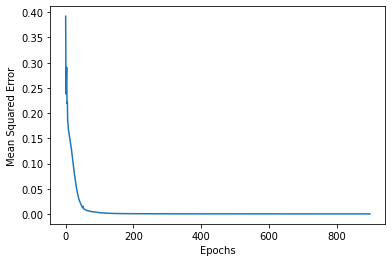

In [150]:
sai=FFSNNetwork(10,[6,6,3],int_method='he',activitaion_fun='leaky_Relu',leaky_slope=0.01)

sai.fit(X_train, Y_train, epochs=900, eta=0.1, algo="GD", gamma=0.6, display_loss=True)

In [145]:
Y_pred_train = sai.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
Y_pred_val = sai.predict(X_val)
Y_pred_binarised_val = (Y_pred_val >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_val = accuracy_score(Y_pred_binarised_val, Y_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 1.0
Validation accuracy 1.0


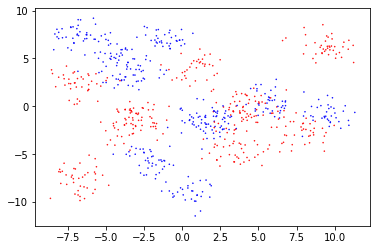

In [146]:

plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_binarised_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_binarised_train-Y_train))+.02))
plt.show()

# mutli class optimized


In [16]:
class FFSNNetwork_mul:
  
  def __init__(self, n_inputs,n_outputs, hidden_sizes=[2],int_method='random',activitaion_fun='sigmoid',leaky_slope=0.01):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    self.int_method=int_method
    self.activitaion_fun=activitaion_fun
    self.leaky_slope=leaky_slope
    self.sizes = [self.nx] + hidden_sizes + [self.ny]
    print(self.sizes)
    np.random.seed(0)
    self.W = {}
    self.B = {}
    self.W_H=[]
    self.B_H=[]
    self.E_H=[]
    self.params={}
    self.update_params={}
    self.prev_update_params={}
    if int_method == "random":
      for i in range(self.nh+1):
        self.params["W"+str(i+1)] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.params["B"+str(i+1)]= np.zeros((1, self.sizes[i+1]))
        # self.temp_params["W"+str(i+1)]=self.W[i+1].copy()
        # self.temp_params["B"+str(i+1)]=self.B[i+1].copy()
    elif int_method == "zeros":
      for i in range(self.nh+1):
        self.params["W"+str(i+1)] = np.zeros((self.sizes[i], self.sizes[i+1]))
        self.params["B"+str(i+1)]= np.zeros((1, self.sizes[i+1]))
    elif int_method == "xavier":
      for i in range(self.nh+1):
        self.params["W"+str(i+1)] = np.random.randn(self.sizes[i], self.sizes[i+1])*np.square(1/self.sizes[i])
        self.params["B"+str(i+1)]= np.zeros((1, self.sizes[i+1]))
    elif int_method == "he":
      for i in range(self.nh+1):
        self.params["W"+str(i+1)] = np.random.randn(self.sizes[i], self.sizes[i+1])*np.square(2/self.sizes[i])
        self.params["B"+str(i+1)]= np.zeros((1, self.sizes[i+1]))
    for i in range(self.nh+1):
      # self.temp_params["W"+str(i+1)]=self.W[i+1].copy()
      # self.temp_params["B"+str(i+1)]=self.B[i+1].copy()
      self.update_params["v_w"+str(i+1)]=0
      self.update_params["v_b"+str(i+1)]=0
      self.update_params["m_b"+str(i+1)]=0
      self.update_params["m_w"+str(i+1)]=0
      self.prev_update_params["v_w"+str(i+1)]=0
      self.prev_update_params["v_b"+str(i+1)]=0

  
  def activation_farwoard_pass(self,X):
    if self.activitaion_fun == "sigmoid":
      return 1.0/(1.0 + np.exp(-X))
    elif self.activitaion_fun == "tanh":
      return np.tanh(X)
    elif self.activitaion_fun == "Relu":
      return np.maximum(0,X)
    elif self.activitaion_fun == "leaky_Relu":
      return np.maximum(self.leaky_slope*X,X)
  
  def grad_farword_pass(self,X):
    if self.activitaion_fun == "sigmoid":
      return X*(1-X)
    elif self.activitaion_fun == "tanh":
      return (1-np.square(X))
    elif self.activitaion_fun == "Relu":
      return 1.0*(X>0)
    elif self.activitaion_fun == "leaky_Relu":
      d=np.zeros_like(X)
      d[X<=0]=self.leaky_slope
      d[X>0]=1.0
      return d
  # def sigmoid(self, X):
  #   return 1.0/(1.0 + np.exp(-X))
  
  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X ,params=None):
    if(params is None):
      params=self.params
    self.A = {}
    self.H = {}
    self.H[0]=X
    # self.H[0] = X.reshape(1, -1)
    for i in range(self.nh):
      # print("mat mul{} ** {} ++ {}".format(self.H[i].shape,self.W[i+1].shape,self.B[i+1].shape))
      self.A[i+1] = np.matmul(self.H[i], params["W"+str(i+1)]) + params["B"+str(i+1)] 
      self.H[i+1] = self.activation_farwoard_pass(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh], params["W"+str(self.nh+1)]) + params["B"+str(self.nh+1)]
    # print("input to softmax is{}".format(self.A[self.nh+1]))
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
    # print("output to softmax is{}".format(self.H[self.nh+1]))
    return self.H[self.nh+1]
  
  def grad_sigmoid(self, X):
    return X*(1-X) 
    
  def grad(self, X, Y,params=None):
    if params is None:
      params=self.params

    self.forward_pass(X,params)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    N=Y.shape[0]
    # Y=Y.reshape(N,1)
    # print("HL{}--Y{}".format(self.H[L].shape,Y.shape))
    self.dA[L] = (self.H[L] - Y)
    
    for k in range(L, 0, -1):
      # print(k)
      # print("Dw of k is=={} ** {}".format(self.H[k-1].T.shape,self.dA[k].shape))
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = np.sum(self.dA[k],axis=0).reshape(1,-1)
      # print("DB{}".format(dB[3].shape))
      self.dH[k-1] = np.matmul(self.dA[k], self.params["W"+str(k)].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_farword_pass(self.H[k-1]))
    
  def fit(self, X, Y, algo="GD",epochs=1, initialise=True, display_loss=False,gamma=0.9,eta=1,
          mini_batch_size=100,eps=1e-8,beta=0.9,beta1=0.9,beta2=0.9):
    
    # initialise w, b
    if initialise:

      for i in range(self.nh+1):
        self.params["W"+str(i+1)] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.params["B"+str(i+1)]= np.zeros((1, self.sizes[i+1]))
        self.update_params["v_w"+str(i+1)]=0
        self.update_params["v_b"+str(i+1)]=0
        self.update_params["m_b"+str(i+1)]=0
        self.update_params["m_w"+str(i+1)]=0
        self.prev_update_params["v_w"+str(i+1)]=0
        self.prev_update_params["v_b"+str(i+1)]=0

      
    if display_loss:
      loss = {}
    
    for e in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
      m = X.shape[0]
      # for i in range(self.nh+1):
      #   dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
      #   dB[i+1] = np.zeros((1, self.sizes[i+1]))
      
        # for i in range(self.nh+1):
        #   dW[i+1] += self.dW[i+1]
        #   dB[i+1] += self.dB[i+1]
      if algo=="GD":
        self.grad(X, Y)  
        for i in range(self.nh+1):
          self.params["W"+str(i+1)] -= eta * self.dW[i+1] / m
          self.params["B"+str(i+1)] -= eta * self.dB[i+1] / m
      
      elif algo == "MiniBatch":
        for k in range(0,m,mini_batch_size):
          self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
          for i in range(self.nh+1):
            self.params["W"+str(i+1)] -= eta * (self.dW[i+1]/mini_batch_size)
            self.params["B"+str(i+1)] -= eta * (self.dB[i+1]/mini_batch_size)
      
      elif algo=="Momentum":
        self.grad(X,Y)
        for i in range(self.nh+1):
          self.update_params["v_w"+str(i+1)] = gamma *self.update_params["v_w"+str(i+1)] + eta * (self.dW[i+1]/m)
          self.update_params["v_b"+str(i+1)] = gamma *self.update_params["v_b"+str(i+1)] + eta * (self.dB[i+1]/m)
          self.params["W"+str(i+1)] -= self.update_params["v_w"+str(i+1)]
          self.params["B"+str(i+1)] -= self.update_params["v_b"+str(i+1)]
      elif algo == "NAG":
        temp_params = {}
        for i in range(self.nh+1):
          self.update_params["v_w"+str(i+1)]=gamma*self.prev_update_params["v_w"+str(i+1)]
          self.update_params["v_b"+str(i+1)]=gamma*self.prev_update_params["v_b"+str(i+1)]
          temp_params["W"+str(i+1)]=self.params["W"+str(i+1)]-self.update_params["v_w"+str(i+1)]
          temp_params["B"+str(i+1)]=self.params["B"+str(i+1)]-self.update_params["v_b"+str(i+1)]
        self.grad(X,Y,temp_params)
        for i in range(self.nh+1):
          self.update_params["v_w"+str(i+1)] = gamma *self.update_params["v_w"+str(i+1)] + eta * (self.dW[i+1]/m)
          self.update_params["v_b"+str(i+1)] = gamma *self.update_params["v_b"+str(i+1)] + eta * (self.dB[i+1]/m)
          self.params["W"+str(i+1)] -= eta * (self.update_params["v_w"+str(i+1)])
          self.params["B"+str(i+1)] -= eta * (self.update_params["v_b"+str(i+1)]) 
        self.prev_update_params=self.update_params
      
      elif algo == "AdaGrad":
        self.grad(X, Y)
        for i in range(self.nh+1):
          self.update_params["v_w"+str(i+1)] += (self.dW[i+1]/m)**2
          self.update_params["v_b"+str(i+1)] += (self.dB[i+1]/m)**2
          self.params["W"+str(i+1)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i+1)])+eps)) * (self.dW[i+1]/m)
          self.params["B"+str(i+1)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i+1)])+eps)) * (self.dB[i+1]/m)
     
      elif algo == "RMSProp":
        self.grad(X, Y)
        for i in range(self.nh+1):
          self.update_params["v_w"+str(i+1)] = beta*self.update_params["v_w"+str(i+1)] +(1-beta)*((self.dW[i+1]/m)**2)
          self.update_params["v_b"+str(i+1)] = beta*self.update_params["v_b"+str(i+1)] +(1-beta)*((self.dB[i+1]/m)**2)
          self.params["W"+str(i+1)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i+1)]+eps)))*(self.dW[i+1]/m)
          self.params["B"+str(i+1)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i+1)]+eps)))*(self.dB[i+1]/m)
      
      
      elif algo == "Adam":
        self.grad(X, Y)
        num_updates=0
        for i in range(self.nh+1):
          num_updates+=1
          self.update_params["m_w"+str(i+1)]=beta1*self.update_params["m_w"+str(i+1)]+(1-beta1)*(self.dW[i+1]/m)
          self.update_params["v_w"+str(i+1)]=beta2*self.update_params["v_w"+str(i+1)]+(1-beta2)*((self.dW[i+1]/m)**2)
          m_w_hat=self.update_params["m_w"+str(i+1)]/(1-np.power(beta1,num_updates))
          v_w_hat=self.update_params["v_w"+str(i+1)]/(1-np.power(beta2,num_updates))
          self.params["W"+str(i+1)] -=(eta/np.sqrt(v_w_hat+eps))*m_w_hat
          
          self.update_params["m_b"+str(i+1)]=beta1*self.update_params["m_b"+str(i+1)]+(1-beta1)*(self.dB[i+1]/m)
          self.update_params["v_b"+str(i+1)]=beta2*self.update_params["v_b"+str(i+1)]+(1-beta2)*((self.dB[i+1]/m)**2)
          m_b_hat=self.update_params["m_b"+str(i+1)]/(1-np.power(beta1,num_updates))
          v_b_hat=self.update_params["v_b"+str(i+1)]/(1-np.power(beta2,num_updates))
          self.params["B"+str(i+1)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat

      if display_loss:
        Y_pred = self.predict(X)
        loss[e] = log_loss(np.argmax(Y, axis=1), Y_pred)
    
    if display_loss:
      plt.plot(np.array(list(loss.values())))
      plt.xlabel('Epochs')
      plt.ylabel('Mean Squared Error')
      plt.show()
      
  def predict(self, X):
    Y_pred1 = []
    y_pred = self.forward_pass(X)
    Y_pred1.append(y_pred)
    return np.array(Y_pred1).squeeze()

[10, 10, 10, 20]


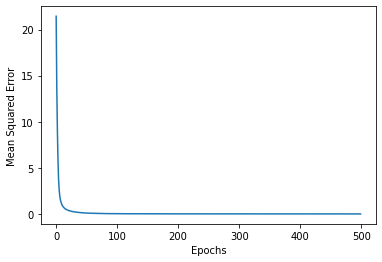

CPU times: user 2.13 s, sys: 10.9 ms, total: 2.14 s
Wall time: 2.14 s


In [176]:
%%time
sai2=FFSNNetwork_mul(10,20,[10,10],activitaion_fun='leaky_Relu',int_method='he',leaky_slope=0.1)
sai2.fit(X_train_m,y_OH_train,algo='GD',epochs=500,eta=0.1,display_loss=True)

In [177]:
Y_pred_train = sai2.predict(X_train_m)
Y_pred_train = np.argmax(Y_pred_train,1)

Y_pred_val = sai2.predict(X_val_m)
Y_pred_val = np.argmax(Y_pred_val,1)

accuracy_train = accuracy_score(Y_pred_train, Y_train_m)
accuracy_val = accuracy_score(Y_pred_val, Y_val_m)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 1.0
Validation accuracy 0.99


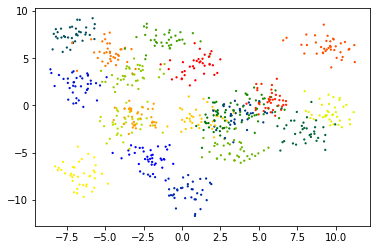

In [178]:
plt.scatter(X_train_m[:,0], X_train_m[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train_m))+.1))
plt.show()

[10, 16, 12, 20]


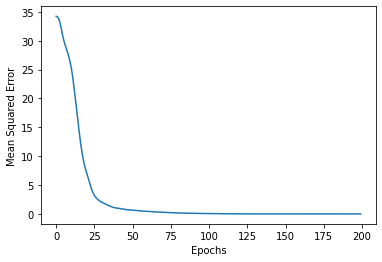

CPU times: user 1.06 s, sys: 18 ms, total: 1.08 s
Wall time: 1.1 s


In [197]:
%%time
sai2=FFSNNetwork_mul(10,20,[16,12],activitaion_fun='leaky_Relu',int_method='he',leaky_slope=0.01)
sai2.fit(X_train_m, y_OH_train, epochs=200, eta=.01, algo="Adam", beta=0.9, display_loss=True)

In [198]:
Y_pred_train = sai2.predict(X_train_m)
Y_pred_train = np.argmax(Y_pred_train,1)

Y_pred_val = sai2.predict(X_val_m)
Y_pred_val = np.argmax(Y_pred_val,1)

accuracy_train = accuracy_score(Y_pred_train, Y_train_m)
accuracy_val = accuracy_score(Y_pred_val, Y_val_m)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 1.0
Validation accuracy 0.99


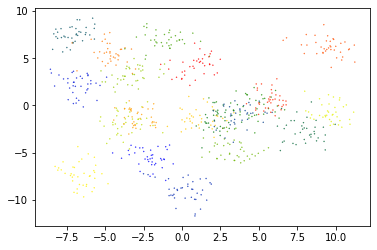

In [200]:
plt.scatter(X_train_m[:,0], X_train_m[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train_m))+.01))
plt.show()

Exercise

0. Duplicate this exercise for our smaller network with 3 neurons (binary classification). In this case, you can practise writing the vectorised form of the gradient descent. 

1. After training for a few epochs, freeze updates to all variables, except two (say w_1 and w_2 in our diagram). Now we have a situation similar to the previous setting (where there are two variables and we can plot 2d and 3d plots). Plot the error surface and animate to visualise each algorithm. 

2. Try 1. with different parameters (say w_3, b_2) and observe how the algorithms work
